In [18]:
import zipfile
import os

# Function to unzip the archive and extract it to the specified directory
def unzip_archive(zip_path, extract_path='.'):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

In [19]:
# Function to display folder structure and file count
def show_folder_structure_and_file_count(path='.'):

    folder_info = {}

    for root, dirs, files in os.walk(path):
        # Count the number of files in the current directory
        file_count = len(files)
        folder_info[root] = file_count

    # Print summary of folder structure and file counts
    for folder, count in folder_info.items():
        print(f'{folder}: {count} files')

# Example usage
zip_path = '/content/drive/MyDrive/Colab Notebooks/Facial Images Dataset/archive.zip'  # Replace with the path to your zip file
extract_path = '/content/Facial_Expression'

# Unzip the archive
unzip_archive(zip_path, extract_path)

# Show folder structure and file count
show_folder_structure_and_file_count(extract_path)

/content/Facial_Expression: 0 files
/content/Facial_Expression/test: 0 files
/content/Facial_Expression/test/angry: 958 files
/content/Facial_Expression/test/surprise: 831 files
/content/Facial_Expression/test/fear: 1024 files
/content/Facial_Expression/test/neutral: 1233 files
/content/Facial_Expression/test/sad: 1247 files
/content/Facial_Expression/test/disgust: 111 files
/content/Facial_Expression/test/happy: 1774 files
/content/Facial_Expression/train: 0 files
/content/Facial_Expression/train/angry: 3995 files
/content/Facial_Expression/train/surprise: 3171 files
/content/Facial_Expression/train/fear: 4097 files
/content/Facial_Expression/train/neutral: 4965 files
/content/Facial_Expression/train/sad: 4830 files
/content/Facial_Expression/train/disgust: 436 files
/content/Facial_Expression/train/happy: 7215 files


In [20]:
! pip install --upgrade tensorflow keras


In [29]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
import os


In [30]:
train_dir = '/content/Facial_Expression/train'
test_dir = '/content/Facial_Expression/test'
# Data generators with augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical'
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [31]:
# Model architecture with dropout and batch normalization
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [37]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [38]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
# Callbacks for learning rate reduction and early stopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

In [39]:
# Training the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    validation_data=test_generator,
    validation_steps=len(test_generator),
    callbacks=[reduce_lr, early_stopping]
)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 68s 68ms/step - accuracy: 0.2064 - loss: 2.2776 - val_accuracy: 0.2992 - val_loss: 1.8156 - learning_rate: 0.0010
Epoch 2/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 20us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/50
  2/898 ━━━━━━━━━━━━━━━━━━━━ 49s 55ms/step - accuracy: 0.2344 - loss: 1.8968 

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/callback_list.py:151: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate
  current = self.get_monitor_value(logs)


898/898 ━━━━━━━━━━━━━━━━━━━━ 58s 65ms/step - accuracy: 0.2561 - loss: 1.8118 - val_accuracy: 0.0496 - val_loss: 28.1086 - learning_rate: 0.0010
Epoch 4/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 18us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 5/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 56s 62ms/step - accuracy: 0.2596 - loss: 1.7913 - val_accuracy: 0.3023 - val_loss: 1.7094 - learning_rate: 0.0010
Epoch 6/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 7/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 59s 65ms/step - accuracy: 0.2757 - loss: 1.7540 - val_accuracy: 0.2898 - val_loss: 1.8135 - learning_rate: 0.0010
Epoch 8/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 130us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 9/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 57s 64ms/step - accuracy: 0.2910 - loss: 1.7443 - val_accuracy: 0.2916 - val_loss: 1.8011 - learning_rate: 0.0010
Epoch 10/50
898/898 ━━━━━━━━━━━━━━━━━

In [40]:
print(test_generator.class_indices)
print(test_generator.samples)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
7178


In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    validation_data=test_generator,
    validation_steps=len(test_generator)
)


Epoch 1/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 63s 70ms/step - accuracy: 0.4126 - loss: 1.5160 - val_accuracy: 0.4850 - val_loss: 1.3627
Epoch 2/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 57s 63ms/step - accuracy: 0.4141 - loss: 1.5120 - val_accuracy: 0.4870 - val_loss: 1.3593
Epoch 4/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 14us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 56s 63ms/step - accuracy: 0.4082 - loss: 1.5160 - val_accuracy: 0.4791 - val_loss: 1.3487
Epoch 6/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 14us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 56s 62ms/step - accuracy: 0.4116 - loss: 1.5105 - val_accuracy: 0.4797 - val_loss: 1.3884
Epoch 8/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 168us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 55s 61ms/step - accuracy: 0.4240 - loss: 1.5040 - val_accura

225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step


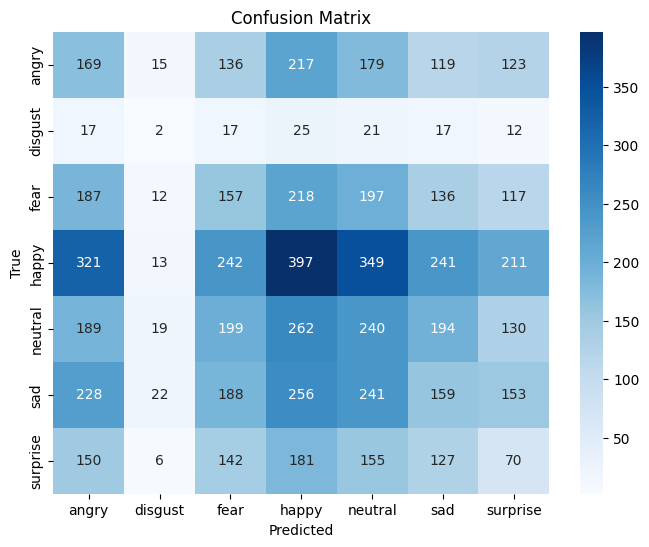

In [12]:
# Required Libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, recall_score
import seaborn as sns

# Step 1: Evaluate on Test Set
test_generator.reset()  # Ensure the generator starts from the beginning
Y_pred = model.predict(test_generator, steps=len(test_generator))
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes

# Step 2: Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()




In [13]:
# Step 3: Classification Report
class_report = classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys())
print("Classification Report:\n", class_report)

# Step 4: F1 Score, Recall, and Accuracy
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')

print(f'Accuracy Score: {accuracy}')
print(f'F1 Score: {f1}')
print(f'Recall Score: {recall}')



Classification Report:
               precision    recall  f1-score   support

       angry       0.13      0.18      0.15       958
     disgust       0.02      0.02      0.02       111
        fear       0.15      0.15      0.15      1024
       happy       0.26      0.22      0.24      1774
     neutral       0.17      0.19      0.18      1233
         sad       0.16      0.13      0.14      1247
    surprise       0.09      0.08      0.09       831

    accuracy                           0.17      7178
   macro avg       0.14      0.14      0.14      7178
weighted avg       0.17      0.17      0.17      7178

Accuracy Score: 0.16634159933129006
F1 Score: 0.1668812910484738
Recall Score: 0.16634159933129006


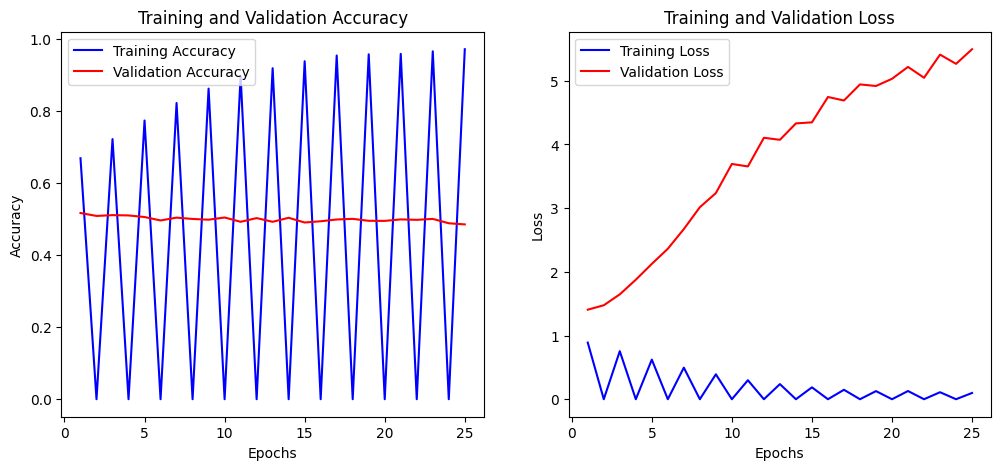

In [15]:
# Get the minimum length to plot accurately
min_len = min(len(history.history['accuracy']), len(history.history['val_accuracy']))
epochs = range(1, min_len + 1)

# Accuracy Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['accuracy'][:min_len], 'b', label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'][:min_len], 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'][:min_len], 'b', label='Training Loss')
plt.plot(epochs, history.history['val_loss'][:min_len], 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()
